# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [2]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 


In [3]:
# URL do site
URL = "https://ycharts.com/companies/TSLA/revenues"

# Making the request to the website
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}
response = requests.get(URL, headers=headers)
time.sleep(10)

# We check if the request was successful
if response.status_code == 200:
    html_content = response.text
    print("HTML downloaded successfully")
else:
    print(f"Error downloading the page: {response.status_code}")



# Creating the BeautifulSoup object to parse the HTML
soup = BeautifulSoup(html_content, "html.parser")

tables = soup.find_all("table", class_="table")

#dates = []
#values = []

#for table in tables:
    #rows = table.find("tbody").find_all("tr")
    #for row in rows:
        #date = row.find_all("td")[0].text.strip()
        #value = row.find_all("td")[1].text.strip()

        #dates.append(date)
        #values.append(value)
        
# USING COMPREHENSION LIST 
dates = [row.find_all("td")[0].text.strip() for table in tables for row in table.find("tbody").find_all("tr")]
values =[row.find_all("td")[1].text.strip() for table in tables for row in table.find("tbody").find_all("tr")]


df = pd.DataFrame({
    "Date": dates,
    "Revenue": values
})
print(df)

HTML downloaded successfully
                               Date Revenue
0                     June 30, 2024  25.50B
1                    March 31, 2024  21.30B
2                 December 31, 2023  25.17B
3                September 30, 2023  23.35B
4                     June 30, 2023  24.93B
..                              ...     ...
59  Gross Profit Margin (Quarterly)  17.95%
60        Profit Margin (Quarterly)   5.80%
61                   Earnings Yield   1.61%
62         Operating Earnings Yield   0.94%
63        Normalized Earnings Yield   1.677

[64 rows x 2 columns]


In [4]:
df['Revenue'] = df['Revenue'].str.replace('$', '', regex=True)
df['Revenue'] = df['Revenue'].str.replace('B', 'e9', regex=True)  # Convert 'B' to billions (e9)
df['Revenue'] = df['Revenue'].str.replace('M', 'e6', regex=True)  # Convert 'M' to millions (e6)
df['Revenue'] = pd.to_numeric(df['Revenue'], errors='coerce')  # Convert to number

# Convert the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%B %d, %Y', errors='coerce')

# Delete rows with invalid dates or entries
df.dropna(inplace=True)

# Display the clean DataFrame
print(df)

         Date       Revenue
0  2024-06-30  2.550000e+10
1  2024-03-31  2.130000e+10
2  2023-12-31  2.517000e+10
3  2023-09-30  2.335000e+10
4  2023-06-30  2.493000e+10
5  2023-03-31  2.333000e+10
6  2022-12-31  2.432000e+10
7  2022-09-30  2.145000e+10
8  2022-06-30  1.693000e+10
9  2022-03-31  1.876000e+10
10 2021-12-31  1.772000e+10
11 2021-09-30  1.376000e+10
12 2021-06-30  1.196000e+10
13 2021-03-31  1.039000e+10
14 2020-12-31  1.074000e+10
15 2020-09-30  8.771000e+09
16 2020-06-30  6.036000e+09
17 2020-03-31  5.985000e+09
18 2019-12-31  7.384000e+09
19 2019-09-30  6.303000e+09
20 2019-06-30  6.350000e+09
21 2019-03-31  4.541000e+09
22 2018-12-31  7.226000e+09
23 2018-09-30  6.824000e+09
24 2018-06-30  4.002000e+09
25 2018-03-31  3.409000e+09
26 2017-12-31  3.288000e+09
27 2017-09-30  2.985000e+09
28 2017-06-30  2.790000e+09
29 2017-03-31  2.696000e+09
30 2016-12-31  2.285000e+09
31 2016-09-30  2.298000e+09
32 2016-06-30  1.270000e+09
33 2016-03-31  1.147000e+09
34 2015-12-31  1.214

In [5]:
# Save to CSV file
df.to_csv('tesla_revenues.csv', index=False)

In [6]:
# Connect to the database
con =sqlite3.connect("Tesla_revenues.db")

# Create a cursor to execute SQL commands
cursor = con.cursor()

# Create the table in the database
cursor.execute('''
CREATE TABLE IF NOT EXISTS revenue (
    Date REAL, 
    Revenue REAL
)
''')


# Convert the DataFrame into a list of tuples to insert in the bank
tesla_revenues_tuples = list(df[['Date', 'Revenue']].itertuples(index=False, name=None))


# Insert the data into the table
for index, row in df.iterrows():
    cursor.execute('''
        INSERT INTO revenue (Date, Revenue)
        VALUES (?, ?)
    ''', (row['Date'].strftime('%Y-%m-%d'), row['Revenue']))

# Confirm the changes in the data bank
con.commit()

# Close the connection
con.close()

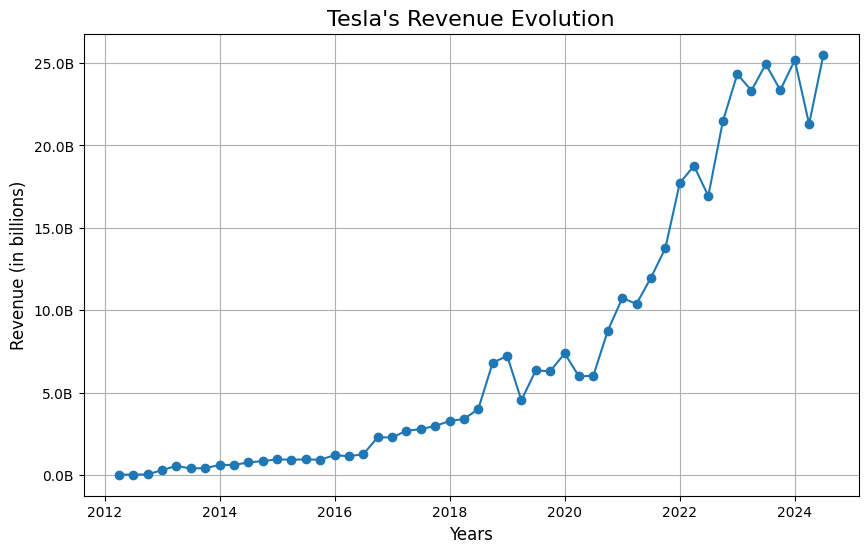

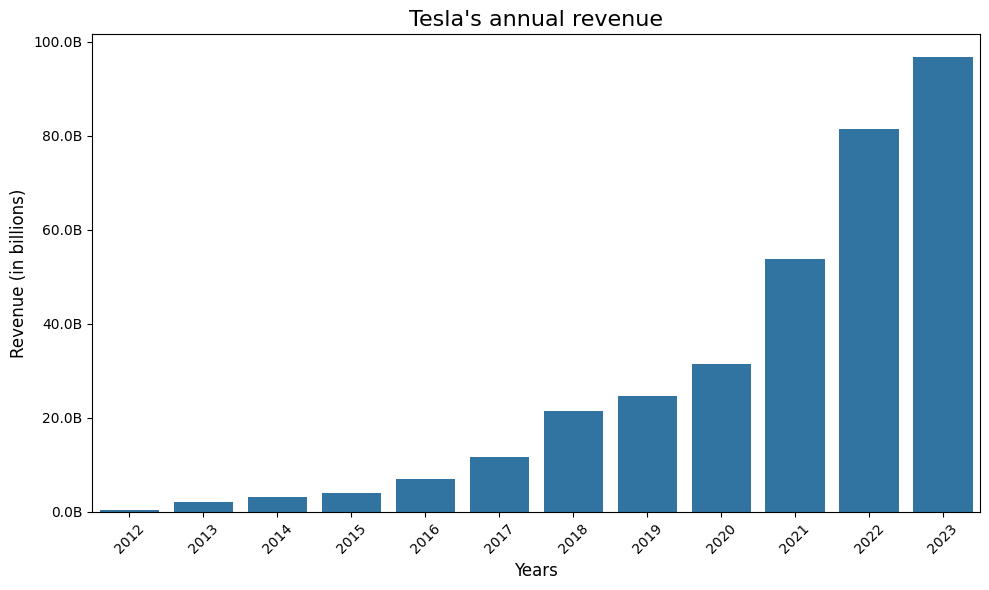

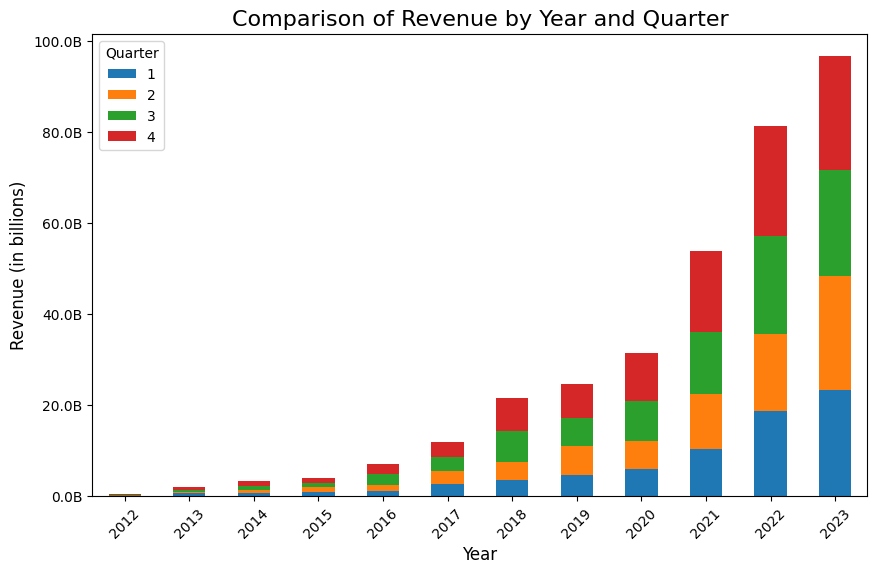

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Line chart: Evolution of Tesla's revenue

plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Revenue'], marker='o')
plt.title("Tesla's Revenue Evolution", fontsize=16)
plt.xlabel('Years', fontsize=12)
plt.ylabel('Revenue (in billions)', fontsize=12)
formatter = plt.FuncFormatter(lambda x, _: f'{x * 1e-9:.1f}B')
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.show()

# 2. Bar Chart: Annual Tesla's revenue
df['Year'] = df['Date'].dt.year
df_final = df[df['Year'] != 2024]

df_grouped = df_final.groupby('Year').agg({'Revenue': 'sum'}).reset_index()
df_grouped['Year'] = df_grouped['Year'].astype(int)
df_grouped = df_grouped.sort_values(by='Year')
plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='Revenue', data= df_grouped)  # Mostramos los últimos 10 trimestres
plt.xticks(rotation=45)
plt.title("Tesla's annual revenue", fontsize=16)
plt.xlabel('Years', fontsize=12)
plt.ylabel('Revenue (in billions)', fontsize=12)
formatter = plt.FuncFormatter(lambda x, _: f'{x * 1e-9:.1f}B')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()



# 3. Stacked Bar Chart: Comparison of Revenue by Year and Quarter
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter
df_final = df[df['Year'] != 2024]
pivot_df = df_final.pivot_table(values='Revenue', index='Year', columns='Quarter', aggfunc='sum')

pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xticks(rotation=45)
plt.title('Comparison of Revenue by Year and Quarter', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Revenue (in billions)', fontsize=12)
formatter = plt.FuncFormatter(lambda x, _: f'{x * 1e-9:.1f}B')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()
